### Integrantes
- Alanis Gonzalez Sebastian
- Raya Ríos Vania Janet
- Martínez Jiménez Israel
- Fonseca González Bruno

# Proyecto Final Paradigmas y Programación

**Definición del proyecto:**

Dado un conjunto de reseñas que el usuario escriba sobre peliculas especificas, identificar cuales reseñas son positivas y cuales negativas usando:


*   Clasificador Bayesiano Multinomial
*   Regresión Logistica

Posteriormente, se recomendarán peliculas en base a las reseñas que los modelos hayan clasificado como positivas usando kNN Vecinos con la métrica de Coseno (usamos coseno ya que como vamos a analizar overview, genres y keywords, entonces las películas con descripciones textuales similares tendrán vectores con *direcciones similares*, incluso si uno tiene más palabras clave).

**Objetivo:**

Combinar análisis de sentimientos y recomendaciones de películas para crear un sistema que pueda personalizar las sugerencias según las preferencias del usuario.



# Preprocesamiento

In [46]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import re
import numpy as np

In [ ]:
### Buenas practicas

# En caso de que clases no esten balanceadas
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV # Buscar el mejor parámetro
from sklearn.model_selection import learning_curve # Problemas de sobreajuste o subajuste
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report # Métricas
from sklearn.pipeline import Pipeline # Automatizamos con pipelines

Además del dataset movies.csv, primero usaremos el dataset IMDBDataset.csv para entrenar a los modelos y el cual contiene 50,000 reseñas de películas clasificadas en negativas o positivas.

In [ ]:
reviews_positive_negative = pd.read_csv('/content/IMDBDataset.csv')
reviews_positive_negative.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Preprocesamiento
reviews_positive_negative.sentiment = reviews_positive_negative.sentiment.map({'positive':0, 'negative':1})
reviews_positive_negative.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [ ]:
# Notamos que el dataset contiene símbolos de markdown, por lo que lo quitamos con la librería 'regular expressions'
reviews_positive_negative['review'] = reviews_positive_negative['review'].apply(
    lambda x: re.sub('<.*?>', '', x).lower()
)
reviews_positive_negative.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,0
1,a wonderful little production. the filming tec...,0
2,i thought this was a wonderful way to spend ti...,0
3,basically there's a family where a little boy ...,1
4,"petter mattei's ""love in the time of money"" is...",0


In [ ]:
# Separamos en entrnamientos y pruebas
X_train, X_test, y_train, y_test = train_test_split(reviews_positive_negative.review, reviews_positive_negative.sentiment, random_state = 1)
reviews_positive_negative.shape, X_train.shape, X_test.shape

((50004, 2), (37503,), (12501,))

In [ ]:
print(X_train.shape, y_train.shape)
print(X_train.head(), y_train.head())


(37503,) (37503,)
25773    at long last! one of michael jackson's most we...
31783    first off, i really loved henry fool, which pu...
33822    we've all seen this story a hundred times. you...
18644    an intelligent and well obtained film worth to...
36168    unfortunately, i've never seen the full versio...
Name: review, dtype: object 25773    0
31783    1
33822    1
18644    0
36168    0
Name: sentiment, dtype: int64


In [ ]:
print(reviews_positive_negative['sentiment'].value_counts())
# Porcentajes de cada clase
porcentajes = reviews_positive_negative['sentiment'].value_counts() / len(reviews_positive_negative) * 100
print(porcentajes)

# Clases balanceadas por lo que no es necesario que usemos stratified k-fold cross-validation

sentiment
1    25004
0    25000
Name: count, dtype: int64
sentiment
1    50.004
0    49.996
Name: count, dtype: float64


# Clasificador Bayesiano Multinomial

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
pipeline_NB = Pipeline([
    ('cv', CountVectorizer(stop_words = 'english')),
    ('nb', MultinomialNB())
])

In [ ]:
# Buscamos el mejor parámetro
parametros = {
    'nb__alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
}
buscar_en_grid = GridSearchCV(pipeline_NB, parametros, cv=5, scoring='accuracy', n_jobs = -1)
buscar_en_grid.fit(X_train, y_train)

print("Mejor parámetro:", buscar_en_grid.best_params_)
print("Mejor exactitud:", buscar_en_grid.best_score_)

Mejor parámetro: {'nb__alpha': 1.0}
Mejor exactitud: 0.8543048873483535


In [ ]:
### Predicciones con y_test
modelo_NB = buscar_en_grid.best_estimator_
y_pred_nb = modelo_NB.predict(X_test)


In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.8532117430605551
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      6222
           1       0.84      0.88      0.86      6279

    accuracy                           0.85     12501
   macro avg       0.85      0.85      0.85     12501
weighted avg       0.85      0.85      0.85     12501



In [ ]:
### Curva de aprendizaje

train_sizes, train_scores, test_scores = learning_curve(
    pipeline_NB, X = X_train, y = y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy', n_jobs=-1
)

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1) #  variabilidad en diferentes pliegues
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

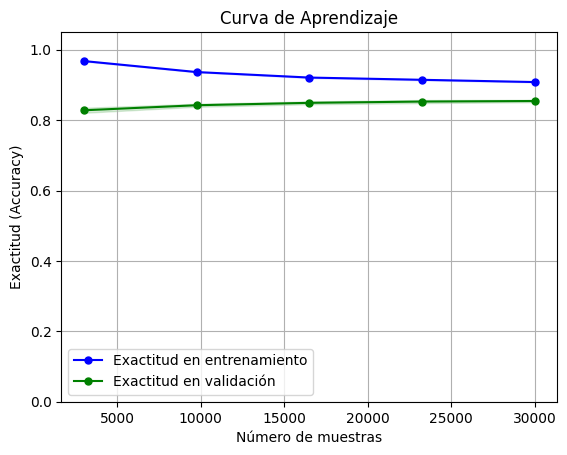

In [ ]:
# Entrenamiento
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Exactitud en entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, color='blue', alpha=0.15)

# Pruebas
plt.plot(train_sizes, test_mean, color='green', marker='o', markersize=5, label='Exactitud en validación')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='green', alpha=0.15)

# Amenidades
plt.grid()
plt.xlabel('Número de muestras')
plt.ylabel('Exactitud (Accuracy)')
plt.legend(loc='best')
plt.ylim([0.0, 1.05])
plt.title('Curva de Aprendizaje')
plt.show()

* Exactitud en entramiento: Esto quiere decir que a medida que se agrega más data, el modelo generaliza mejor y no solo memoriza, lo que causa la ligera disminución en la exactitud del entrenamiento.

* Cuando el modelo entrena con pocas muestras, no aprende lo suficiente para generalizar bien, lo que da un rendimiento bajo en los datos de validación. Eventualmente, se estabiliza entre 85% y 90%.

# Regresión Logistica

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
pipeline_LR = Pipeline([
    ('cv', CountVectorizer(stop_words = 'english')),
    ('lr', LogisticRegression(penalty = 'l2'))
])

In [ ]:
# Buscamos el mejor parámetro
parametros = {
    'lr__C': [0.01, 0.1, 1]
}
buscar_en_grid_LR = GridSearchCV(pipeline_LR, parametros, cv=3, scoring='accuracy', n_jobs = -1)
buscar_en_grid_LR.fit(X_train, y_train)

print("Mejores parámetros:", buscar_en_grid_LR.best_params_)
print("Mejor exactitud:", buscar_en_grid_LR.best_score_)

Mejores parámetros: {'lr__C': 0.1}
Mejor exactitud: 0.8848358797962829


In [ ]:
### Predicciones con y_test
modelo_LR = buscar_en_grid_LR.best_estimator_
y_pred_lr = modelo_LR.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.8860891128709704
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      6222
           1       0.90      0.87      0.89      6279

    accuracy                           0.89     12501
   macro avg       0.89      0.89      0.89     12501
weighted avg       0.89      0.89      0.89     12501



In [24]:
### Curva de aprendizaje

train_sizes, train_scores, test_scores = learning_curve(
    pipeline_LR, X = X_train, y = y_train, cv=3, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy', n_jobs=-1
)

In [25]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1) #  variabilidad en diferentes pliegues
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

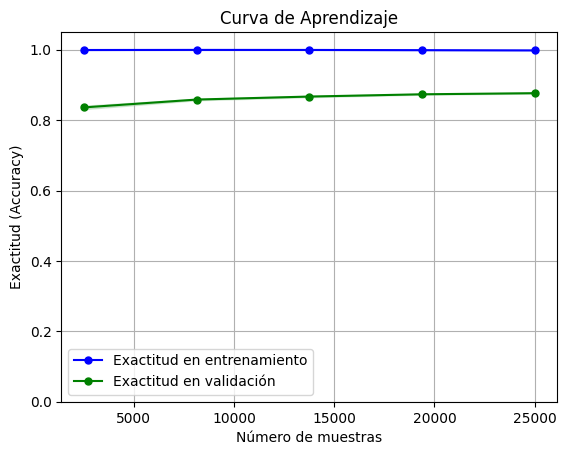

In [26]:
# Entrenamiento
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Exactitud en entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, color='blue', alpha=0.15)

# Pruebas
plt.plot(train_sizes, test_mean, color='green', marker='o', markersize=5, label='Exactitud en validación')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='green', alpha=0.15)

# Amenidades
plt.grid()
plt.xlabel('Número de muestras')
plt.ylabel('Exactitud (Accuracy)')
plt.legend(loc='best')
plt.ylim([0.0, 1.05])
plt.title('Curva de Aprendizaje')
plt.show()

# **Comparación final:** ¿Cuál modelo clasifica mejor?

In [27]:
resultados_metricas = {
    'Modelo': [],
    'Accuracy': [],
    'F1-Score': [],
    'Precision': [],
    'Recall': []
}

# Evaluar modelos y guardar métricas
for modelo_nombre, y_pred in [
    ('Logistic Regression', y_pred_lr),
    ('Multinomial NB', y_pred_nb)
]:
    resultados_metricas['Modelo'].append(modelo_nombre)
    resultados_metricas['Accuracy'].append(accuracy_score(y_test, y_pred))
    resultados_metricas['F1-Score'].append(f1_score(y_test, y_pred, average='weighted'))
    resultados_metricas['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
    resultados_metricas['Recall'].append(recall_score(y_test, y_pred, average='weighted'))

# Convertir a DataFrame
metricas_df = pd.DataFrame(resultados_metricas)
print(metricas_df)

                Modelo  Accuracy  F1-Score  Precision    Recall
0  Logistic Regression  0.886089  0.886078   0.886336  0.886089
1       Multinomial NB  0.853212  0.853130   0.853829  0.853212


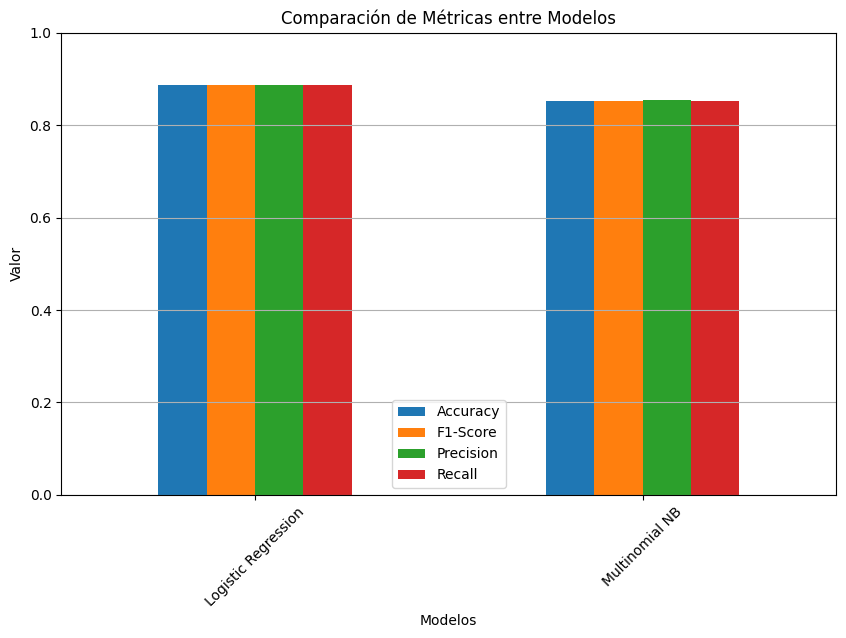

In [28]:
metricas_df.set_index('Modelo').plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de Métricas entre Modelos')
plt.ylabel('Valor')
plt.xlabel('Modelos')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(axis='y')
plt.show()


# Sistema de recomendaciones

Una vez entrenado el modelo, podemos crear nuestro sistema de recomendacion de películas, el cual consiste de las siguientes funciones:

1. buscar_peliculas: Busca películas en movies.csv en base a palabras clave o títulos que el usuario escriba.
2. reseñar_peliculas: Permite que el usuario escriba múltiples películas y que les de su reseña a cada una de ellas.
3. predecir_reseña: Predice si la reseña es 'positiva' o 'negativa' dependiendo del modelo.
4. recomendar: Recomienda películas basado en el título y los generos de la(s) película(s) clasificada(s) como positiva(s).

In [29]:
movies = pd.read_csv('/content/movies.csv')

In [30]:
def buscar_peliculas(movies):

    consultas = input("Ingrese los títulos o palabras clave de las películas que desea buscar, separados por comas: ").lower().split(',')
    consultas = [query.strip() for query in consultas]

    pelis_filtradas = movies[movies['title'].str.lower().str.contains('|'.join(consultas), na=False)]

    if pelis_filtradas.empty:
        print("No se encontraron películas que coincidan con la búsqueda.")
        return pd.DataFrame()

    pelis_filtradas = pelis_filtradas.sort_values(by=['popularity', 'vote_average'], ascending=[False, False])

    print("\n--- Resultados de la Búsqueda ---")
    for i, row in pelis_filtradas.iterrows():
        print(f"{i}: {row['title']} (Géneros: {row['genres']}) | Popularidad: {row.get('popularity', 'N/A')} | Voto promedio: {row.get('vote_average', 'N/A')}")

    return pelis_filtradas


In [31]:
def reseñar_peliculas(movies):

    pelis_filtradas = buscar_peliculas(movies)

    if pelis_filtradas.empty:
        return []

    ids = input("\nIngrese los números de las películas que desea reseñar, separados por comas: ").split(',')
    ids = [int(movie_id.strip()) for movie_id in ids if movie_id.strip().isdigit()]

    reseñas = []
    for movie_id in ids:
        if movie_id in pelis_filtradas.index:
            movie = pelis_filtradas.loc[movie_id]
            print(f"\nReseña de: {movie['title']} (Géneros: {movie['genres']})")
            reseña = input("Escriba su reseña para esta película (positiva o negativa): ")
            reseñas.append((movie['title'], reseña))
        else:
            print(f"El ID {movie_id} no está en la lista.")

    return reseñas

In [32]:
def predecir_reseña_NB(review):
    sentimiento = modelo_NB.predict([review])[0]
    return "positive" if sentimiento == 0 else "negative"

In [33]:
def predecir_reseña_LR(review):
    sentimiento = modelo_LR.predict([review])[0]
    return "positive" if sentimiento == 0 else "negative"

# Recomendar con kNN vecinos

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd

def recomendar_peliculas_KNN(peliculas_positivas, peliculas_negativas, movies, num_recomendaciones=5):
    movies['combined_features'] = (
        movies['genres'].fillna('') + ' ' +
        movies['keywords'].fillna('') + ' ' +
        movies['overview'].fillna('')
    )

    vectorizador = CountVectorizer(stop_words='english')
    matriz_caracteristicas = vectorizador.fit_transform(movies['combined_features'])

    knn = NearestNeighbors(metric='cosine', n_neighbors=num_recomendaciones + 1) # mas 1 para que excluya a si misma
    knn.fit(matriz_caracteristicas)

    peliculas_recomendadas = []
    for _, pelicula in peliculas_positivas.iterrows():
        indice_pelicula = movies[movies['title'] == pelicula['title']].index[0]
        distancias, indices = knn.kneighbors(matriz_caracteristicas[indice_pelicula], n_neighbors=num_recomendaciones + 1)
        peliculas_similares = indices.flatten()[1:]
        peliculas_recomendadas.extend(movies.iloc[peliculas_similares].to_dict(orient='records'))

    recomendaciones_df = pd.DataFrame(peliculas_recomendadas).drop_duplicates(subset='title') # Elimina duplicados en caso de que se clasifique más de una peli como positiva

    if not peliculas_negativas.empty:
        titulos_excluidos = []
        for _, pelicula in peliculas_negativas.iterrows():
            indice_pelicula = movies[movies['title'] == pelicula['title']].index[0]
            distancias, indices = knn.kneighbors(matriz_caracteristicas[indice_pelicula], n_neighbors=num_recomendaciones + 1)
            peliculas_similares = indices.flatten()[1:]
            titulos_excluidos.extend(movies.iloc[peliculas_similares]['title'].tolist())

        recomendaciones_df = recomendaciones_df[~recomendaciones_df['title'].isin(titulos_excluidos)]

    return recomendaciones_df[['title', 'genres', 'popularity', 'vote_average']].sort_values(
        by=['popularity', 'vote_average'], ascending=[False, False]
    )

In [ ]:
ruto

In [45]:
if __name__ == "__main__":
    while True:
        reseñas = reseñar_peliculas(movies)

        pelis_positivas = []
        pelis_negativas = []

        for titulo, reseña in reseñas:
            sentimiento = predecir_reseña_NB(reseña)
            print(f"\nSu reseña para '{titulo}' fue clasificada como: {sentimiento}")

            pelicula_seleccionada = movies[movies['title'].str.lower() == titulo.lower()]
            if not pelicula_seleccionada.empty:
                if sentimiento == "positive":
                    pelis_positivas.append(pelicula_seleccionada.iloc[0])
                else:
                    pelis_negativas.append(pelicula_seleccionada.iloc[0])

        peliculas_positivas_df = pd.DataFrame(pelis_positivas)
        peliculas_negativas_df = pd.DataFrame(pelis_negativas)

        if not peliculas_positivas_df.empty:
            print("\nGenerando recomendaciones basadas en tus películas positivas...")
            recomendaciones_df = recomendar_peliculas_KNN(peliculas_positivas_df, peliculas_negativas_df, movies, num_recomendaciones=5)


            if not recomendaciones_df.empty:
                print("\nPelículas similares que podrían gustarte:")
                for _, row in recomendaciones_df.iterrows():
                    print(f"{row['title']} ({row['genres']}) | Popularidad: {row['popularity']}, Voto promedio: {row['vote_average']}")
            else:
                print("No se encontraron películas para recomendar.")
        else:
            print("No tienes películas positivas para generar recomendaciones.")

        decision = input("\n¿Desea buscar y reseñar otras películas? (s/n): ").lower()
        if decision != 's':
            print("¡Gracias por usar nuestro sistema de recomendaciones!")
            break


--- Resultados de la Búsqueda ---
361: The Batman (Géneros: Crime, Mystery, Thriller) | Popularidad: 100.817 | Voto promedio: 7.705
40: Batman Begins (Géneros: Action, Crime, Drama) | Popularidad: 66.286 | Voto promedio: 7.701
4015: Naruto Shippuden the Movie (Géneros: Animation, Action, Fantasy) | Popularidad: 62.202 | Voto promedio: 7.371
2219: The Last: Naruto the Movie (Géneros: Action, Romance, Animation) | Popularidad: 41.554 | Voto promedio: 7.758
2771: Boruto: Naruto the Movie (Géneros: Animation, Action, Comedy) | Popularidad: 41.024 | Voto promedio: 7.595
476: Batman (Géneros: Fantasy, Action, Crime) | Popularidad: 40.79 | Voto promedio: 7.2
3591: Road to Ninja: Naruto the Movie (Géneros: Animation, Fantasy, Action) | Popularidad: 38.342 | Voto promedio: 7.588
5040: Naruto Shippuden the Movie: Blood Prison (Géneros: Thriller, Animation, Action, Comedy, Horror, Mystery) | Popularidad: 34.84 | Voto promedio: 7.313
6051: Naruto Shippuden the Movie: The Will of Fire (Géneros: Ac

KeyboardInterrupt: Interrupted by user

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import joblib

def recomendar_peliculas_KNN_Tfid(peliculas_positivas, peliculas_negativas, movies, num_recomendaciones=5):
    try:
        vectorizador = joblib.load('vectorizador.joblib')
        matriz_caracteristicas = joblib.load('matriz_caracteristicas.joblib')
        knn = joblib.load('knn_model.joblib')
    except FileNotFoundError:

        movies['combined_features'] = (
            movies['genres'].fillna('') + ' ' +
            movies['keywords'].fillna('') + ' ' +
            movies['overview'].fillna('')
        )

        # Vectorización
        vectorizador = TfidfVectorizer(stop_words='english')
        matriz_caracteristicas = vectorizador.fit_transform(movies['combined_features'])

        # Guardar el vectorizador y la matriz
        joblib.dump(vectorizador, 'vectorizador.joblib')
        joblib.dump(matriz_caracteristicas, 'matriz_caracteristicas.joblib')

        # Entrenar el modelo KNN
        knn = NearestNeighbors(metric='cosine', n_neighbors=20, algorithm='brute')
        knn.fit(matriz_caracteristicas)
        joblib.dump(knn, 'knn_model.joblib')

    peliculas_recomendadas = []

    # Asegurarse de que las películas tengan identificadores únicos
    movies = movies.drop_duplicates(subset='id')

    # Procesar películas positivas
    for _, pelicula in peliculas_positivas.iterrows():
        indices_pelicula = movies[movies['id'] == pelicula['id']].index
        if indices_pelicula.empty:
            continue
        indice_pelicula = indices_pelicula[0]
        distancias, indices = knn.kneighbors(matriz_caracteristicas[indice_pelicula], n_neighbors=num_recomendaciones + 1)
        peliculas_similares = indices.flatten()[1:]
        peliculas_recomendadas.extend(movies.iloc[peliculas_similares].to_dict(orient='records'))

    recomendaciones_df = pd.DataFrame(peliculas_recomendadas).drop_duplicates(subset='id')

    # Excluir películas similares a las negativas
    if not peliculas_negativas.empty:
        titulos_excluidos = []
        for _, pelicula in peliculas_negativas.iterrows():
            indices_pelicula = movies[movies['id'] == pelicula['id']].index
            if indices_pelicula.empty:
                continue
            indice_pelicula = indices_pelicula[0]
            distancias, indices = knn.kneighbors(matriz_caracteristicas[indice_pelicula], n_neighbors=num_recomendaciones + 1)
            peliculas_similares = indices.flatten()[1:]
            titulos_excluidos.extend(movies.iloc[peliculas_similares]['id'].tolist())

        recomendaciones_df = recomendaciones_df[~recomendaciones_df['id'].isin(titulos_excluidos)]

    # Seleccionar las top N recomendaciones
    recomendaciones_df = recomendaciones_df[['id', 'title', 'genres', 'popularity', 'vote_average']].sort_values(
        by=['popularity', 'vote_average'], ascending=[False, False]
    ).head(num_recomendaciones)

    return recomendaciones_df